In [1]:
import sys
import os

# 获取当前工作目录
current_dir = os.getcwd()

# 获取父目录（即 python_dir）
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)


import numpy as np
import cupy as cp
import mytorch as torch
import mytorch.ops as ops
import mytorch.nn as nn
import mytorch.optim as optim
import mytorch.data as data
from mytorch.array_device import *
import mytorch.perfomance as pf

In [2]:
class ResNet9(nn.Module):
    def __init__(self, device=None, dtype="float32"):
        super().__init__()
        self.block1 = nn.ConvBN(3, 16, 7, 4, device=device, dtype=dtype)
        self.block2 = nn.ConvBN(16, 32, 3, 2, device=device, dtype=dtype)
        self.res1 = nn.Residual(
            nn.Sequential(
                nn.ConvBN(32, 32, 3, 1, device=device, dtype=dtype),
                nn.ConvBN(32, 32, 3, 1, device=device, dtype=dtype)
            )
        )
        self.block3 = nn.ConvBN(32, 64, 3, 2, device=device, dtype=dtype)
        self.block4 = nn.ConvBN(64, 128, 3, 2, device=device, dtype=dtype)
        self.res2 = nn.Residual(
            nn.Sequential(
                nn.ConvBN(128, 128, 3, 1, device=device, dtype=dtype),
                nn.ConvBN(128, 128, 3, 1, device=device, dtype=dtype),
            )
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128, 128, device=device, dtype=dtype)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 10, device=device, dtype=dtype)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.res1(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.res2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x


In [3]:
batch_size=256
epochs=20
net = ResNet9(device=gpu())
optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.001)
criterion= nn.SoftmaxLoss()

In [4]:
x_array = np.random.rand(1,3,32,32)
x = torch.Tensor(x_array)
x.to('gpu')
net(x)

mytorch.Tensor([[ 0.10878853 -0.14578394 -0.03098088  0.95947137  0.62237614  0.46434155
  -0.23100366  0.73578293 -0.90225381 -0.34885203]])

In [5]:
# 获取根目录
from mytorch.data.data_transforms import *
root_dir= os.path.abspath(os.path.join(project_dir, os.pardir))

In [6]:
# 标准化(没有使用其他数据增强是因为发现效果不好,旋转可能效果挺好的，但是需要额外的库就没弄，标准化参数是抄的别人公布的数据）
train_dataset = data.datasets.SVHNDataset(f"{root_dir}/data/SVHN/train_32x32.mat",[Normalize([0.4377, 0.4438, 0.4728],[0.1980, 0.2010, 0.1970])])
train_dataloader = data.DataLoader(\
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True)

test_dataset = data.datasets.SVHNDataset(f"{root_dir}/data/SVHN/test_32x32.mat",[Normalize([0.4377, 0.4438, 0.4728],[0.1980, 0.2010, 0.1970])])
test_dataloader = data.DataLoader(\
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True)

EPOCH 0: avg_accuracy=array(0.47181839), avg_loss=array(1.5567845, dtype=float32)
EPOCH 1: avg_accuracy=array(0.71010279), avg_loss=array(0.90084404, dtype=float32)
EPOCH 2: avg_accuracy=array(0.76993325), avg_loss=array(0.7242864, dtype=float32)
EPOCH 3: avg_accuracy=array(0.80038768), avg_loss=array(0.633256, dtype=float32)
EPOCH 4: avg_accuracy=array(0.82035846), avg_loss=array(0.56514555, dtype=float32)
EPOCH 5: avg_accuracy=array(0.83566076), avg_loss=array(0.5134314, dtype=float32)
EPOCH 6: avg_accuracy=array(0.84905197), avg_loss=array(0.48000503, dtype=float32)
EPOCH 7: avg_accuracy=array(0.85770643), avg_loss=array(0.44778332, dtype=float32)
EPOCH 8: avg_accuracy=array(0.86521425), avg_loss=array(0.4231251, dtype=float32)
EPOCH 9: avg_accuracy=array(0.87285857), avg_loss=array(0.40004823, dtype=float32)
EPOCH 10: avg_accuracy=array(0.87977941), avg_loss=array(0.37741023, dtype=float32)
EPOCH 11: avg_accuracy=array(0.88270063), avg_loss=array(0.36517003, dtype=float32)
EPOCH 12

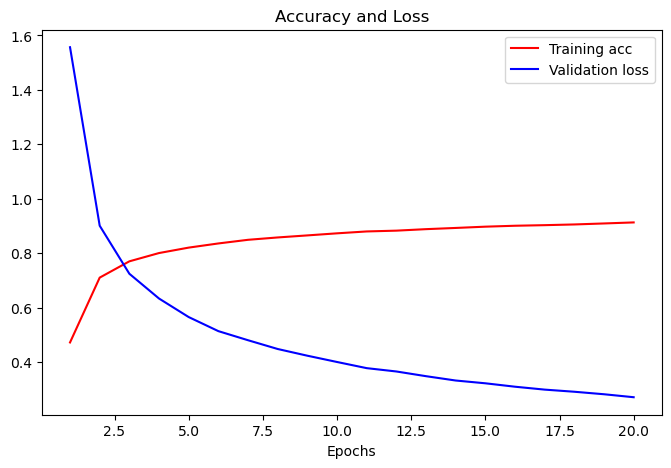

In [7]:
# 训练
pfm = pf.Performance()
for epoch in range(epochs):
    total_loss = 0
    total_rights = 0
    total_examples = 0
    total_batches = 0
    for input,label in train_dataloader:
        input.to('gpu')
        label.to('gpu')
        net.train()
        optimizer.reset_grad()

        pred = net(input)
        loss = criterion(pred,label)
        loss.backward()

        optimizer.step()

        label_pred = cp.argmax(pred.cupy(),axis=1)
        rights = cp.equal(label_pred, label.cupy()).sum()

        total_loss += loss.cupy()
        total_rights += rights
        total_batches += 1
        total_examples += input.shape[0]
    
    avg_loss = total_loss / total_batches
    avg_accuracy = total_rights / total_examples

    pfm.update_in_train(avg_accuracy,avg_loss)

    print(f"EPOCH {epoch}: {avg_accuracy=}, {avg_loss=}")

pfm.graph()

TEST SCORE: avg_accuracy=array(0.78895206), avg_loss=array(0.74391485)


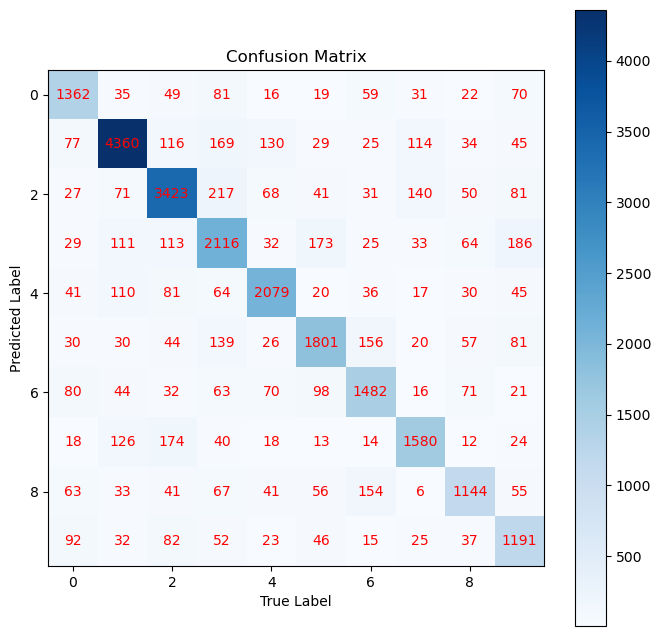

In [8]:
# 测试
total_loss = 0
total_rights = 0
total_examples = 0
total_batches = 0
for input,label in test_dataloader:
    input.to('gpu')
    label.to('gpu')
    net.eval()

    pred = net(input)
    loss = criterion(pred,label)
    label_pred = cp.argmax(pred.cupy(),axis=1)
    rights = cp.equal(label_pred, label.cupy()).sum()

    total_loss += loss.cupy()
    total_rights += rights
    total_batches += 1
    total_examples += input.shape[0]
    pfm.update_in_test(label.cupy(), label_pred)
    
avg_loss = total_loss / total_batches
avg_accuracy = total_rights / total_examples

print(f"TEST SCORE: {avg_accuracy=}, {avg_loss=}")

pfm.matrix(8)